# CONTEXT BEFORE THE CHALLENGE

This notebook contains a challenge and some exercises.

The challenge is about creating an image classifier that can beat the rest of classifiers written by each student.

All the data is ready and the notebook is prepared, so students only have to focus on choosing the best model and the best training hyperparameters.

The notebook is using Python generators to traverse the data, due to its volume (it does not fit in memory). Because of this, some hyperparameters, such as batch size or data augmentation, are chosen in the data preparation section.

## Data download
This notebook can be used on Google Colab, or in a standalone way just using Jupyter. If you are using Jupyter, please download the original data manually, and ignore the cell where PyDrive downloads the data.

The data is downloaded from https://drive.google.com/file/d/1c9va4iRjKZjbHTm_BMOKfbPERaxUKKsn/view?usp=sharing

If you use Google Colab, you will need to authenticate to use PyDrive. Just follow the instructions in the cell that downloads the data.

## Results upload
The results are written in Pickle files. In the section **Share your predictions** you will find a cell to upload the results to Google Drive. If you are using Jupyter, you can upload your Pickle files manually to this folder:
* https://drive.google.com/drive/folders/1_AEHONWOJotSVfn93mtXX5y8SpWi2Etw?usp=sharing

## Cells to be changed by students

Students need to change only the following cells:
* In the **Data preparation** section, we choose the batch size, and parameters for data augmentation (if used). **Change those hyperparameters in these cells**.
* In the **Challenge! Build the mest model you can!** section, you can define the architecture of your model, as well as the loss function, optimization method, etc. **Change your model and hyperparameters here**
* In the **Evaluate model** you can check if your model is overfitting or underfitting. Use this section to decide how to change your model or hyperparameters, and to upload your results.
* In the **Exercises** section, please try to solve all the exercises.

## What about the rest of cells?

This notebook is provided to make your life easier, so you can focus on trying to obtain the best model. Those cells just prepare the data for your model. So **our advice is not to touch those cells and focusing on your model and exercises**.

# Data preparation

And some useful common code.

Run these cells to get the data ready for your model.



In [1]:
%pylab inline
plt.style.use('seaborn-talk')

Populating the interactive namespace from numpy and matplotlib


In [0]:
def plot_metric(history, metric):
    history_dict = history.history
    values = history_dict[metric]
    if 'val_' + metric in history_dict.keys():  
        val_values = history_dict['val_' + metric]

    epochs = range(1, len(values) + 1)

    if 'val_' + metric in history_dict.keys():  
        plt.plot(epochs, val_values, label='Validation')
    plt.semilogy(epochs, values, label='Training')

    if 'val_' + metric in history_dict.keys():  
        plt.title('Training and validation %s' % metric)
    else:
        plt.title('Training %s' % metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()

    plt.show()  

### Working from Local?

If you are not using Google Colab, ignore this cell and download the data from this link:

* https://drive.google.com/file/d/1c9va4iRjKZjbHTm_BMOKfbPERaxUKKsn/view?usp=sharing

Put the ZIP file in the same directory as your notebook.


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1c9va4iRjKZjbHTm_BMOKfbPERaxUKKsn'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("dogs_cats_small.zip")

In [4]:
# Continue from here even if you are running from local

!rm -rf dogs_cats_small
!unzip dogs_cats_small.zip > /dev/null
!ls -hl dogs_cats_small

total 12K
drwxr-xr-x 4 root root 4.0K Nov 28 16:27 test
drwxr-xr-x 4 root root 4.0K Nov 28 16:27 train
drwxr-xr-x 4 root root 4.0K Nov 28 16:27 validation


In [0]:
# CHANGE THIS VARIABLE IF YOU ARE RUNNING FROM LOCAL
BASE_PATH = "/content"  # /content for Google Colab, change if it is different in your case

import os, shutil
base_dir = "%s/dogs_cats_small" % BASE_PATH


train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

## Inspecting some data

The training, validation and test sets are stored in different subdirectories.

Each of those subdirs contains two subdirs, dogs and cats, for the images for each one of the labels.

Let's have a look

This should be a dog:


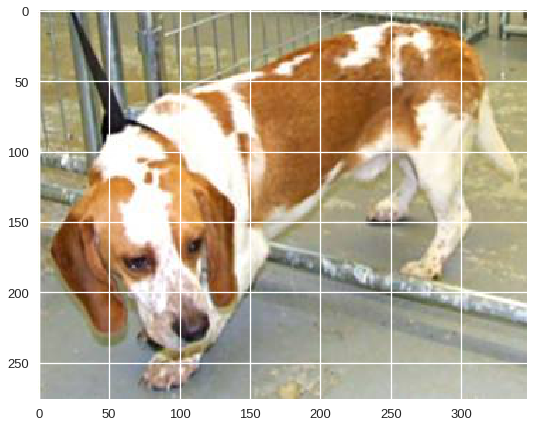

In [6]:
print("This should be a dog:")
plt.imshow(mpl.image.imread('dogs_cats_small/train/dogs/dog.132.jpg'))

This should be a cat:


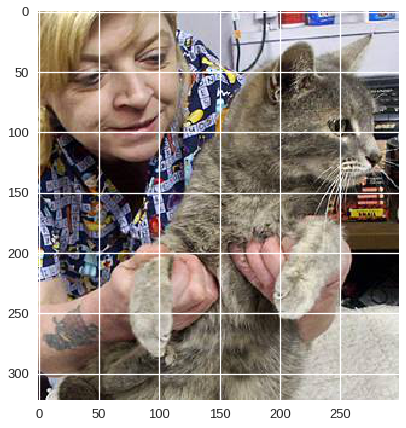

In [7]:
print("This should be a cat:")
plt.imshow(mpl.image.imread('dogs_cats_small/train/cats/cat.257.jpg'))

# Choose your runtime

You can try using a TPU or a GPU.

If you are using a GPU, check that you have actually managed to grab one:

In [8]:
# Check if we have a GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()  # inspect output and try to find out if you have a GPU

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5359143917133621994, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9113409473428398325
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1408638596420453228
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11281553818
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 191599947805612982
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

# Data preparation

The pictures are just too large to train all the dataset in memory. We need to use generators.

**QUESTION**: We are rescaling the images. Why? Is it because we don't have enough memory and this will make the images smaller? What is the effect of rescaling the images?

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
IMG_SIZE=256  # Use with target size to make sure all imgs are of the same size
              # The bigger the better, but memory is finite, so...

# BEAR IN MIND THAT YOU ARE HERE SETTING THE BATCH SIZE
# IF YOU NEED TO CHANGE IT, YOU HAVE TO CREATE THE GENERATORS AGAIN
BATCH_SIZE = 200


train_datagen = ImageDataGenerator(rescale=1.0/255)

# You can also try to use *Data Augmentation* to get a better model
# train_datagen = ImageDataGenerator(
#     rescale=1.0/255,
#     rotation_range=40,
#     width_shift_range=.2,
#     height_shift_range=.2,
#     shear_range=.2,
#     zoom_range=.2,
#     horizontal_flip=True
# )


test_datagen = ImageDataGenerator(rescale=1.0/255)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


test_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Challenge! Build model the best model you can!

Here we build a simple model to illustrate how to train a model with generators.

**CHALLENGE**: What's the best model you can find?

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

In [0]:
# ===================================================
# =                                                 =
# ------->   YOUR MODEL SHOULD GO HERE   <-----------
# =                                                 =
# ===================================================


# If using CPUs or GPUs
def build_model():
  m = models.Sequential()
  m.add(layers.Conv2D(32, (3, 3), activation='elu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
  m.add(layers.Conv2D(32, (3, 3), activation='elu',
                      kernel_regularizer=regularizers.l2(0.01)))
  m.add(layers.MaxPooling2D((2, 2)))
  m.add(layers.Conv2D(64, (3, 3), activation='elu',
                      kernel_regularizer=regularizers.l2(0.01)))
  m.add(layers.MaxPooling2D((2, 2)))
  m.add(layers.Flatten())
  m.add(layers.Dense(64, activation='elu'))
  m.add(layers.Dense(1, activation='sigmoid'))

  return m

In [0]:
# If using TPUs
def keras2tpu(m):
  tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    m,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])))

  return tpu_model


def build_model_tpu():
  m = models.Sequential()
  m.add(layers.Conv2D(64, (3, 3), activation='selu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
  m.add(layers.Conv2D(64, (3, 3), activation='selu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
  m.add(layers.MaxPooling2D((2, 2)))
  m.add(layers.Conv2D(32, (3, 3), activation='selu')) # , input_shape=(IMG_SIZE, IMG_SIZE, 3)
  
  m.add(layers.Dropout(rate=0.3))
  m.add(layers.MaxPooling2D((2, 2)))
  m.add(layers.Conv2D(16, (3, 3), activation='selu')) # , input_shape=(IMG_SIZE, IMG_SIZE, 3)
  m.add(layers.Dropout(rate=0.3))
  m.add(layers.MaxPooling2D((2, 2)))
  m.add(layers.Flatten())
  m.add(layers.Dense(64, activation='relu'))
  m.add(layers.Dense(1, activation='sigmoid'))

  return keras2tpu(m)

In [14]:
m = build_model()  # or m = build_model_tpu()
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                15745088  
__________

In [0]:
m.compile(loss=losses.binary_crossentropy, optimizer=tf.train.AdamOptimizer(), metrics=[metrics.binary_accuracy])

In [0]:
h = m.fit_generator(train_generator, epochs=15, steps_per_epoch=10, validation_data=validation_generator, validation_steps=5)

Epoch 1/15
10/10 [==============================] - 28s 3s/step - loss: 7.9653 - binary_accuracy: 0.4960 - val_loss: 8.5683 - val_binary_accuracy: 0.5000
Epoch 2/15
 9/10 [==========================>...] - ETA: 1s - loss: 8.4792 - binary_accuracy: 0.5017

# Evaluate model

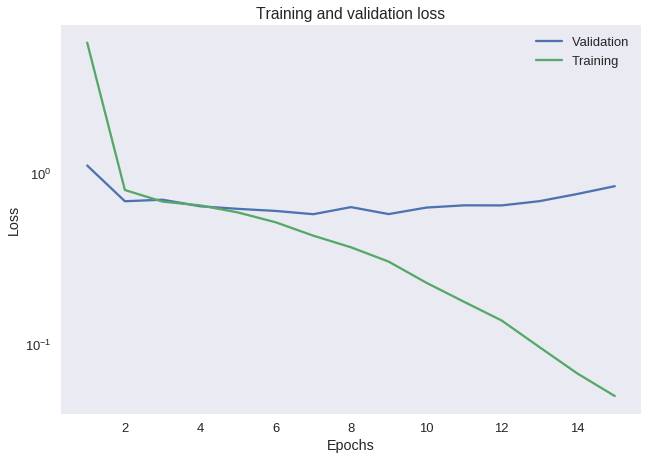

In [24]:
plot_metric(h, 'loss')

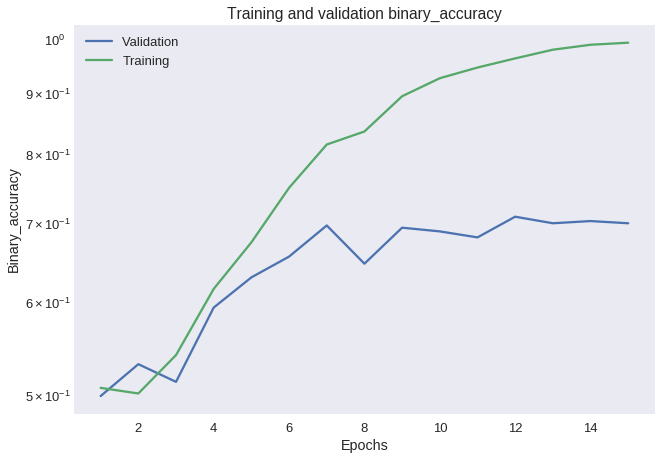

In [25]:
plot_metric(h, 'binary_accuracy')

In [26]:
loss, acc = m.evaluate_generator(test_generator)
loss, acc

(0.8441038489341736, 0.7)

In [0]:
predictions = m.predict_generator(test_generator)

### Share your predictions

To evaluate whether you have done better than others, we need your predictions

Change the name of your team, serialize your predictions and upload to Google Drive.

Please upload to this folder:
* https://drive.google.com/drive/folders/1_AEHONWOJotSVfn93mtXX5y8SpWi2Etw?usp=sharing

To upload, you can use this notebook from Colab, or you can do it manually from the web using the file that is generated in the next 2 cells

In [0]:
import pickle
import datetime

In [29]:
YOUR_TEAM_NAME = "MEP"

filename = "%s_%s.pickle" % (YOUR_TEAM_NAME, datetime.datetime.now().strftime("%Y%m%d_%H%M%S"))

# Serialize object
pickle.dump(predictions, open(filename, 'wb'))

print("Your participation in the challenge is recorded in the file")
print("\n\n   %s\n\n" % filename)
print("Please run the next cell in Google Colab to upload your file.")
print("Alternatively, please upload your file manually to this folder:")
print("https://drive.google.com/drive/folders/1_AEHONWOJotSVfn93mtXX5y8SpWi2Etw?usp=sharing")

Your participation in the challenge is recorded in the file


   MEP_20181214_201207.pickle


Please run the next cell in Google Colab to upload your file.
Alternatively, please upload your file manually to this folder:
https://drive.google.com/drive/folders/1_AEHONWOJotSVfn93mtXX5y8SpWi2Etw?usp=sharing


In [0]:
fid = "1_AEHONWOJotSVfn93mtXX5y8SpWi2Etw"  # don't change, this is the ID of the destination folder
f = drive.CreateFile({"parents": [{"kind": "drive#fileLink", "id": fid}]})
f.SetContentFile(filename)
f.Upload()

In [0]:
test_labels = test_generator.classes.reshape((test_generator.n, 1))

In [0]:
assert predictions.shape == test_labels.shape

# Exercises

**EXERCISE** Can you construct the confusion matrix for this model? Can you calculate the precision and recall? How does it compare to accuracy?
* See https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/

**EXERCISE (more complex)** Keras decided some time ago to remove precision, recall and F1-score from the list of available metrics. Was it a good decision? Why? Why did the Keras' authors did not remove accuracy too?
* https://github.com/keras-team/keras/issues/5794
* https://github.com/keras-team/keras/issues/4592

**EXERCISE** What is the ROC curve? Below we build the ROC curve for our model. How would you use a ROC curve to evaluate a classifier?
* https://en.wikipedia.org/wiki/Receiver_operating_characteristic
* Help: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

In [0]:
# Code to plot a ROC curve
from sklearn import metrics

In [0]:
roc = metrics.roc_curve(test_labels, predictions)
auc = metrics.roc_auc_score(test_labels, predictions)

In [35]:
auc

0.5301279999999999

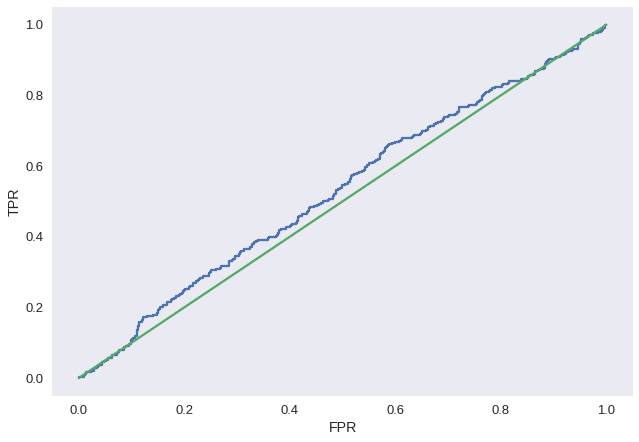

In [36]:
fpr, tpr, _ = roc
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1],'-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()

# INSTRUCTORS ONLY: GRAB ALL THE RESULTS FROM STUDENTS

In [0]:
# STUDENTS: PLEASE IGNORE THIS CELL
# This cell is only for the organizers to read all the data uploaded by the participants

!mkdir -p team_results

# Download all the participations
fid = "1_AEHONWOJotSVfn93mtXX5y8SpWi2Etw"
file_list = [(f['id'], f['originalFilename']) for f in drive.ListFile({'q': "'%s' in parents and trashed=false" % fid}).GetList()]

for pickle_data in file_list:
    pickle_id, pickle_fn = pickle_data
    downloaded = drive.CreateFile({'id': pickle_id})
    downloaded.GetContentFile("team_results/" + pickle_fn)


!ls -hl team_results

# To read the serialized data
# predictions = pickle.load(open('%s.pickle' % YOUR_TEAM_NAME, 'rb'))